In [5]:


import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)






In [6]:


def load():
    data = pd.read_csv("../../datasets/titanic.csv")
    return data


df = load()
df.head()




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [7]:
df.shape


(891, 12)

In [8]:
df.columns = [col.upper() for col in df.columns]

In [9]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


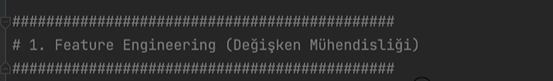

In [10]:
#Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')

#name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()

# name word count 
df["NEW_NAME_WORD_COUNT"] = df ["NAME"].apply(lambda x : len(str(x).split(" ")))



df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))


df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df ["PARCH"] +1 

# AGE_PCLASS
df["NEW_AGE_PCLASS"] =df["AGE"] * df["PCLASS"]

#New Title
df['NEW_TITLE'] = df.NAME.str.extract('([A-Za-z]+)\\.', expand=False)


# is alone 


df.loc[((df['SIBSP'] + df['PARCH'])>0),"NEW_ISALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH'])==0),"NEW_ISALONE"] = "YES"


# AGE level

df.loc[(df['AGE']<18),'NEW_AGE_CAT'] ='young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[df['AGE'] >= 56, 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] <= 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'

df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] <= 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'


df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_TITLE,NEW_ISALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,2,66.000,Mr,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,2,38.000,Mrs,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,1,78.000,Miss,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,2,35.000,Mrs,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,1,105.000,Mr,YES,mature,maturemale


In [11]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)



Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [12]:
num_cols = [col for col in num_cols if col not in "PASSENGERID "]


In [13]:
def outlier_thresholds(dataframe,col_name,q1 = 0.25 , q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 +1.5 * interquantile_range
    low_limit = quartile1 -1.5 *interquantile_range
    return low_limit , up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)  # Değişken adı düzeltildi
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):  # Parantezler ve operatör düzeltildi
        return True
    else:
        return False

In [14]:
for col in num_cols:
    print(col,check_outlier(df,col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [15]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [16]:
for col in num_cols:
    replace_with_thresholds(df,col)

In [17]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_TITLE,NEW_ISALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,2,66.000,Mr,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,65.634,C85,C,1,45,7,0,2,38.000,Mrs,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,1,78.000,Miss,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,2,35.000,Mrs,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,1,105.000,Mr,YES,mature,maturemale


In [18]:
for col in num_cols:
    print(col,check_outlier(df,col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [19]:
def missing_values_table ( datafreame , na_name=False):
    na_columns = [col for col in datafreame.columns if datafreame[col].isnull().sum()>0]
    n_miss = (datafreame[na_columns].isnull().sum()).sort_values(ascending = False)
    ratio = (datafreame[na_columns].isnull().sum() / datafreame.shape[0] * 100 ).sort_values(ascending =False)
    missing_df = pd.concat([n_miss , np.round(ratio,2)] , axis =1 , keys = ['n_miss' , 'ratio'])
    print(missing_df,end="\n")
    if na_columns:
        return na_columns

In [20]:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


['AGE', 'CABIN', 'EMBARKED', 'NEW_AGE_PCLASS', 'NEW_AGE_CAT', 'NEW_SEX_CAT']

In [21]:
# cabin yerine zaten yeni bir değişken oluşturduk 

remove_cols = ["TICKET","NAME","CABIN"]
df.drop(remove_cols,inplace=True,axis=1)

In [22]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_TITLE,NEW_ISALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.000,1,0,7.250,S,0,23,4,0,2,66.000,Mr,NO,mature,maturemale
1,2,1,1,female,38.000,1,0,65.634,C,1,45,7,0,2,38.000,Mrs,NO,mature,maturefemale
2,3,1,3,female,26.000,0,0,7.925,S,0,22,3,0,1,78.000,Miss,YES,mature,maturefemale
3,4,1,1,female,35.000,1,0,53.100,S,1,44,7,0,2,35.000,Mrs,NO,mature,maturefemale
4,5,0,3,male,35.000,0,0,8.050,S,0,24,4,0,1,105.000,Mr,YES,mature,maturemale


In [23]:
missing_values_table(df)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


['AGE', 'EMBARKED', 'NEW_AGE_PCLASS', 'NEW_AGE_CAT', 'NEW_SEX_CAT']

In [24]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))


In [25]:



df["NEW_AGE_PCLASS"] =df["AGE"] * df["PCLASS"]

# is alone 

df.loc[((df['SIBSP'] + df['PARCH'])>0),"NEW_ISALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH'])==0),"NEW_ISALONE"] = "YES"


# AGE level

df.loc[(df['AGE']<18),'NEW_AGE_CAT'] ='young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[df['AGE'] >= 56, 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] <= 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'

df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] <= 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'


df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_TITLE,NEW_ISALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.000,1,0,7.250,S,0,23,4,0,2,66.000,Mr,NO,mature,maturemale
1,2,1,1,female,38.000,1,0,65.634,C,1,45,7,0,2,38.000,Mrs,NO,mature,maturefemale
2,3,1,3,female,26.000,0,0,7.925,S,0,22,3,0,1,78.000,Miss,YES,mature,maturefemale
3,4,1,1,female,35.000,1,0,53.100,S,1,44,7,0,2,35.000,Mrs,NO,mature,maturefemale
4,5,0,3,male,35.000,0,0,8.050,S,0,24,4,0,1,105.000,Mr,YES,mature,maturemale


In [26]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2  0.220


['EMBARKED']

In [27]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "object" and len(x.unique()) <= 10) else x, axis=0)


In [28]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


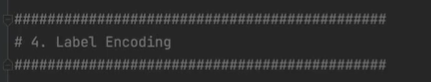

In [29]:
binary_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]
binary_cols

['SEX', 'NEW_ISALONE']

In [30]:
def label_encoder(dataframe , binary_col_name):
    label_encoder = LabelEncoder()
    dataframe[binary_col_name] = label_encoder.fit_transform(dataframe[binary_col_name])
    return dataframe
    

In [31]:
for col in binary_cols:
    df = label_encoder(df,col)

In [32]:
import pandas as pd

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [33]:

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [34]:
rare_cols = rare_analyser(df, "SURVIVED",cat_cols)

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339


NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             7  0.008        0.429
Jonkheer       1  0.001        0.000
Lady           1  0.001        1.000
Major          2  0.002        0.500
Master        40  0.045        0.575
Miss         182  0.204        0.698
Mlle           2  0.002        1.000
Mme            1  0.001        1.000
Mr           517  0.580        0.157
Mrs          125  0.140        0.792
Ms             1  0.001        1.000
Rev            6  0.007    

In [35]:
df = rare_encoder(df,0.01)

df["NEW_TITLE"].value_counts()

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

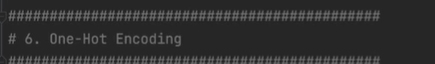

In [36]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique()>2]
ohe_cols

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NEW_NAME_WORD_COUNT',
 'NEW_FAMILY_SIZE',
 'NEW_TITLE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [37]:
def one_hot_encoder(dataframe, categorical_cols , drop_first=True):
    dataframe = pd.get_dummies(dataframe , columns=categorical_cols , drop_first=drop_first)
    return dataframe

In [38]:
df=one_hot_encoder(df,ohe_cols)

In [39]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_ISALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
1,2,1,0,38.000,65.634,1,45,0,38.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,22,0,78.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,44,0,35.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,24,0,105.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


In [40]:
df.shape

(891, 52)

In [41]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [42]:
num_cols

['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [43]:
num_cols = [col for col in num_cols if col not in "PASSENGERID "]


In [44]:
rare_cols = rare_analyser(df, "SURVIVED",cat_cols)

SURVIVED : 2
          COUNT  RATIO  TARGET_MEAN
SURVIVED                           
0           549  0.616        0.000
1           342  0.384        1.000


SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


NEW_CABIN_BOOL : 2
                COUNT  RATIO  TARGET_MEAN
NEW_CABIN_BOOL                           
0                 687  0.771        0.300
1                 204  0.229        0.667


NEW_NAME_DR : 2
             COUNT  RATIO  TARGET_MEAN
NEW_NAME_DR                           
0              881  0.989        0.383
1               10  0.011        0.500


NEW_ISALONE : 2
             COUNT  RATIO  TARGET_MEAN
NEW_ISALONE                           
0              354  0.397        0.506
1              537  0.603        0.304


PCLASS_2 : 2
          COUNT  RATIO  TARGET_MEAN
PCLASS_2                           
False       707  0.793        0.361
True        184  0.207        0.473


PCLASS_3 : 

In [45]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and 
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

In [46]:
useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [47]:
df.drop(useless_cols,axis=1,inplace=True)

In [48]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_ISALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,PARCH_1,PARCH_2,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
1,2,1,0,38.000,65.634,1,45,0,38.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,22,0,78.000,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,44,0,35.000,0,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,24,0,105.000,1,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


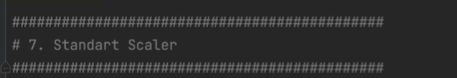

In [49]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.561,-0.821,-0.437,0.066
1,0.663,2.032,2.248,-0.790
2,-0.255,-0.788,-0.559,0.434
3,0.434,1.419,2.126,-0.882
4,0.434,-0.781,-0.315,1.260


In [50]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_ISALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,PARCH_1,PARCH_2,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,-0.561,-0.821,0,-0.437,0,0.066,0,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
1,2,1,0,0.663,2.032,1,2.248,0,-0.790,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,3,1,0,-0.255,-0.788,0,-0.559,0,0.434,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,4,1,0,0.434,1.419,1,2.126,0,-0.882,0,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,5,0,1,0.434,-0.781,0,-0.315,0,1.260,1,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


In [51]:
df.shape

(891, 42)

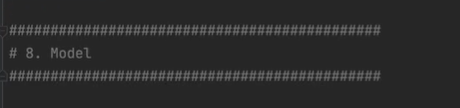

In [52]:
y = df["SURVIVED"]

X = df.drop(["PASSENGERID","SURVIVED"],axis=1)

In [53]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.30 ,random_state=17)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train,y_train)

y_pred = rf_model.predict(X_test)

accuracy_score(y_pred,y_test)

0.8246268656716418

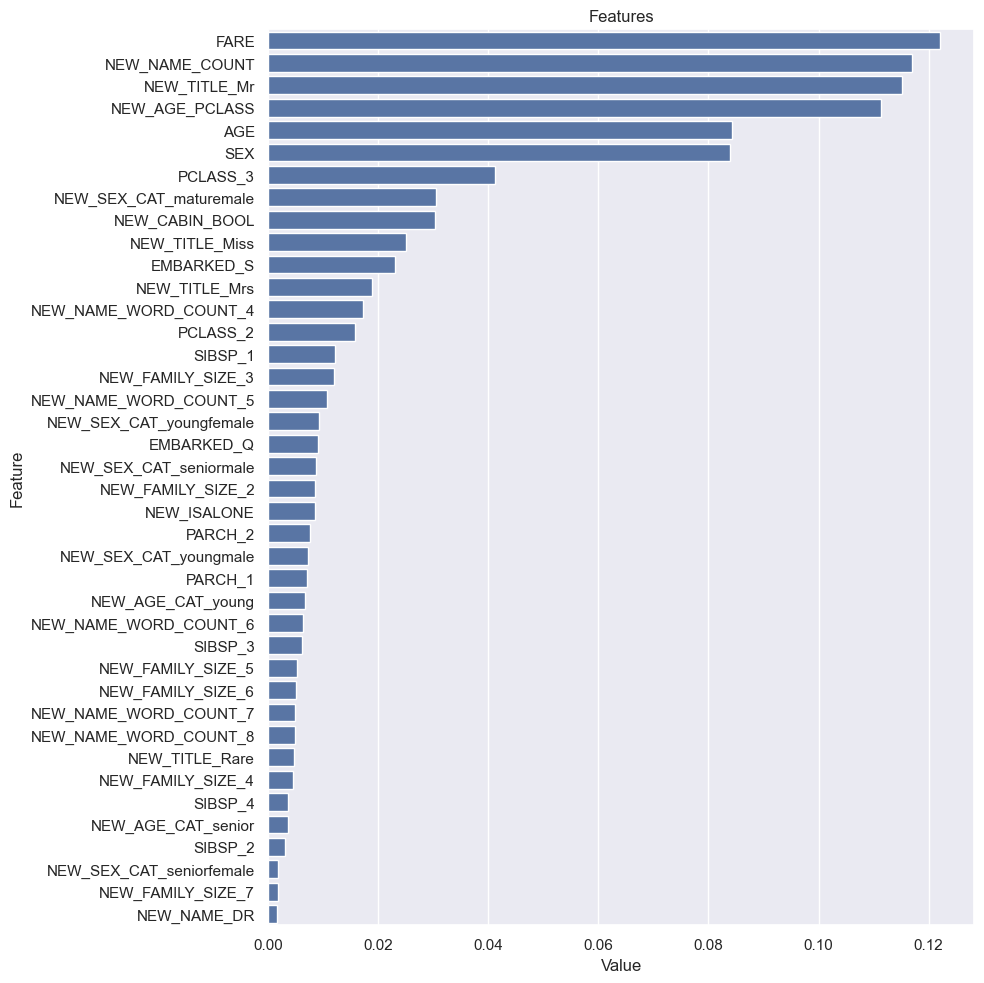

In [56]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)